In [1]:
from glob import glob

import pandas as pd
import matplotlib.pyplot as plt

from Bio import SeqIO

import passenger

In [2]:
blast_paths = glob("passenger-blast/[567]_Ig*.tsv")
#prefix = "8a"
#mut_freq_name = prefix+"_mut_freq"
chigy = passenger.CHIGY_HC
max_mutation_count = 10
max_n_count = 10
# 2 or 3 gap segments, which corresponds to 0 or 1 indels
allowable_gap_segment_counts = [2, 3]

In [3]:
passenger.test_summarize_alignment()
passenger.test_correct_alignment()
passenger.test_summarize_alignment()
passenger.test_compute_mutation_counts_by_base()

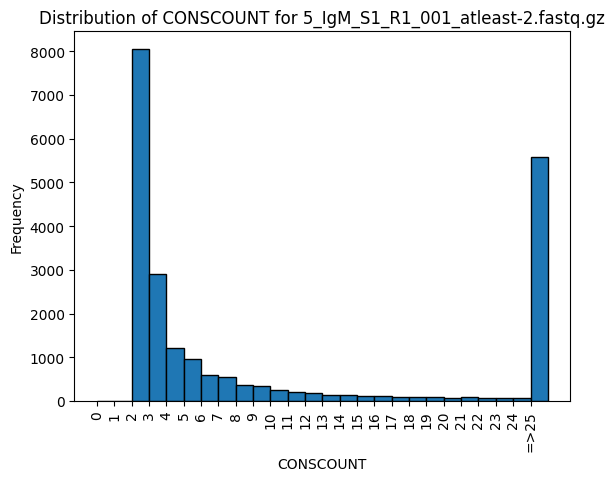

In [4]:
conscounts = passenger.umi_histogram("input/5_IgM_S1_R1_001_atleast-2.fastq.gz", 25)

<Axes: >

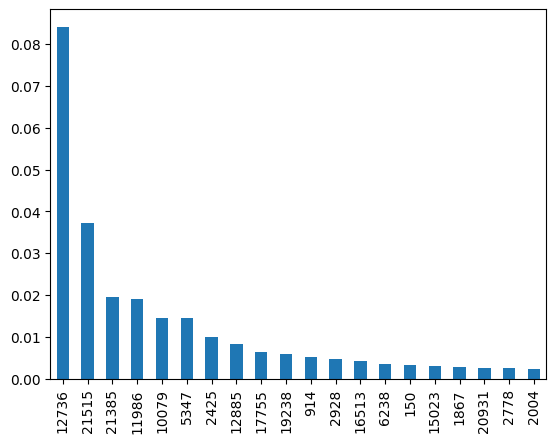

In [5]:
# The fraction of reads in the most abundant UMIs:
(pd.Series(conscounts).sort_values(ascending=False).head(20) / sum(conscounts)).plot.bar()

In [6]:
blast_df = passenger.blast_df_of_blast_files(blast_paths)

duplicates = blast_df[blast_df.duplicated("subject")].copy()
duplicates.sort_values("subject", inplace=True)
duplicates.reset_index(drop=True).loc[0, "subject"]

Original length: 23502
Unique length: 23498
Original length: 27698
Unique length: 27680
Original length: 35452
Unique length: 35421
Original length: 43194
Unique length: 43124


'AAACGGGGGTAAAATGG|PRCONS=Mus-p5-IgM|SEQORIENT=F|CREGION=Mouse-IGHM-InternalC|CONSCOUNT=2|DUPCOUNT=1'

In [7]:
single_blast_df = passenger.read_blast_file(blast_paths[-1])

# find rows with duplicate "subject" values
# (these are the rows with multiple hits)
duplicates = single_blast_df[single_blast_df.duplicated("subject")]
duplicates.sort_values("subject", inplace=True)
duplicates.reset_index(drop=True).loc[0, "subject"]


/var/folders/16/pkph6n2962g3lf2wpwwt0wwr0000gn/T/ipykernel_43344/3703944832.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicates.sort_values("subject", inplace=True)


'AAAGGAAGCGCTATGAG|PRCONS=Mus-p5-IgM|SEQORIENT=F|CREGION=Mouse-IGHM-InternalC|CONSCOUNT=2582|DUPCOUNT=27'

In [8]:
blast_df.sort_values("dataset", inplace=True)

read_comparison_df = pd.DataFrame(blast_df["dataset"].value_counts().sort_index())
read_comparison_df.rename(columns={"count": "chigy_count"}, inplace=True)
read_comparison_df["fasta_count"] = 0

for dataset in read_comparison_df.index:
    fasta_path = f"passenger-blast/{dataset}.fasta"
    # count the number of reads in the fasta file
    read_comparison_df.loc[dataset, "fasta_count"] = len(list(SeqIO.parse(fasta_path, "fasta")))

read_comparison_df["chigy_fraction"] = read_comparison_df["chigy_count"] / read_comparison_df["fasta_count"]

read_comparison_df

,chigy_count,fasta_count,chigy_fraction
dataset,,,
5_IgG_S4_R1_001_atleast-2,7545,32334,0.233346
5_IgM_S1_R1_001_atleast-2,10452,22312,0.468447
6_IgG_S5_R1_001_atleast-2,5505,21402,0.257219
6_IgM_S2_R1_001_atleast-2,7742,14863,0.520891
7_IgG_S6_R1_001_atleast-2,4196,15991,0.262398
7_IgM_S3_R1_001_atleast-2,7754,14602,0.531023


In [9]:
processed_stop_df = chigy.processed_stop_df_of_blast_df(blast_df)
# processed_stop_df

processed_stop_df["dataset"].value_counts().sort_index()

dataset
5_IgG_S4_R1_001_atleast-2     7545
5_IgM_S1_R1_001_atleast-2    10452
6_IgG_S5_R1_001_atleast-2     5505
6_IgM_S2_R1_001_atleast-2     7742
7_IgG_S6_R1_001_atleast-2     4196
7_IgM_S3_R1_001_atleast-2     7754
Name: count, dtype: int64

In [10]:
processed_stop_df["mutation_count"].value_counts()[:20].sort_index()

mutation_count
0       7826
1      13727
2       7432
3       4483
4       2827
5       1778
6       1150
7        617
8        394
9        246
10       113
11        62
118       53
119       47
120       65
121       61
123       49
124       49
125       46
136       46
Name: count, dtype: int64

In [11]:
chigy_believable = processed_stop_df[(processed_stop_df["mutation_count"] < max_mutation_count) & (processed_stop_df["n_count"] < max_n_count) & (processed_stop_df["bookended_by_gaps"] == True)].copy()

chigy_believable


,subject,identity,length,mismatches,gap_openings,q_start,q_end,s_start,s_end,evalue,...,dataset,sequence,gap_segment_count,bookended_by_gaps,mutation_positions,mutation_bases,n_positions,mutation_count,n_count,Sequence number
14164,GGGAACGAAGCGAGAAG|PRCONS=Mus-p5-IgGb|SEQORIENT...,100.0,20,0,0,1,20,107,126,0.000075,...,5_IgG_S4_R1_001_atleast-2,ACATNACAGCNAGAGAGTGTCCGGTTAGTCTCAAGGAAGACTGAGA...,2,True,"[148, 247]","[T, G]",[],2,0,14164
14165,TTAAACTCGCGTCTGAC|PRCONS=Mus-p5-IgGb|SEQORIENT...,100.0,20,0,0,1,20,100,119,0.000075,...,5_IgG_S4_R1_001_atleast-2,GAAGAGAGAGTGTCCGGTTAGTCTCAAGGNAGACTGAGACACAGTC...,2,True,"[94, 168]","[C, G]","[232, 263, 274, 280]",2,4,14165
14167,CGAGAAGTATTGGCAAG|PRCONS=Mus-p5-IgGb|SEQORIENT...,100.0,20,0,0,1,20,99,118,0.000075,...,5_IgG_S4_R1_001_atleast-2,GAAAGAAAGTGTCCGGTTAGTCTCAAGGAAGACTGAGACACAGTCT...,2,True,"[96, 114, 153, 257]","[C, G, G, A]",[],4,0,14167
14169,GCAGAAAAAACAATAAC|PRCONS=Mus-p5-IgGb|SEQORIENT...,100.0,20,0,0,1,20,76,95,0.000075,...,5_IgG_S4_R1_001_atleast-2,GAAGGAAGACTGAGACACAGTCTTAGATATCACCATGGGATGGTCA...,2,True,[280],[C],[],1,0,14169
14171,ACGGGCGGAGTAAACGG|PRCONS=Mus-p5-IgGa|SEQORIENT...,100.0,20,0,0,1,20,108,127,0.000075,...,5_IgG_S4_R1_001_atleast-2,GACATAACAGCAAGTGAGTGTCCGGTTAGTCTCAAGGAAGACTGAG...,2,True,[],[],[],0,0,14171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38586,ATGGACGTGATTGATTT|PRCONS=Mus-p5-IgM|SEQORIENT=...,95.0,20,1,0,1,20,106,125,0.008000,...,7_IgM_S3_R1_001_atleast-2,GATAACAGCAAGAGAGTGTCCGGTTAGTCTCAAGGAAGACTGAGAC...,2,True,[155],[G],[],1,0,38586
38587,TTGCTGGATCCGCTTCT|PRCONS=Mus-p5-IgM|SEQORIENT=...,95.0,20,1,0,1,20,98,117,0.008000,...,7_IgM_S3_R1_001_atleast-2,GAAGAGAGTGTCCGGTTAGTCTCAAGGAAGACTGAGACACAGTCTT...,2,True,[],[],[],0,0,38587
38588,GCAGACGGGGGAGTAAC|PRCONS=Mus-p5-IgM|SEQORIENT=...,95.0,20,1,0,1,20,106,125,0.008000,...,7_IgM_S3_R1_001_atleast-2,GATAACAGCAAGAGAGTGTCCGGTTAGTCTCAAGGAAGACTGAGAC...,2,True,[],[],[],0,0,38588
38579,TAATGAAATTGTTGCAT|PRCONS=Mus-p5-IgM|SEQORIENT=...,95.0,20,1,0,1,20,106,125,0.008000,...,7_IgM_S3_R1_001_atleast-2,GATAACAGCAAGAGAGTGTCCGGTTAGTCTCAAGGAAGACTGAGAC...,2,True,[],[],[],0,0,38579


In [12]:
# Find representatives of the various gap counts
representative_gap_counts = chigy_believable.drop_duplicates(subset=["gap_segment_count"])
representative_gap_counts = representative_gap_counts.sort_values(by=["gap_segment_count"])
chigy.pretty_print_alignments(representative_gap_counts)

> 5_IgG_S4_R1_001_atleast-2 14164
----------------------------------------------------------------------------------------------------------------------------GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTCAGACTCTGTCCCTCACCTGTTCTGTCACTGGCGACTCCATCACCAGTGGTTACTGGAACTGGATCCGGAAATTCCCAGGGAATAAACTTGAGTACATGGGGTACATAAGCTACAGTGGTAGCACTTACTACAATCCATCTCTCAAAAGTCGAATCTCCATCACTCGAGACACATCCAAGAACCAGTACTACCTGCAGTTGAATTCTGTGACTACTGAGGACACAGCCACATATTACTGTGCAAGGGACTTCGATGTCTGGGGCGCAGGGACCACGGTCACCGTCTCCTCAG--------------------
                                                                                                                            ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||                    
AC

In [13]:
chigy_believable = chigy_believable[chigy_believable["gap_segment_count"].isin(allowable_gap_segment_counts)]
chigy_believable["mutation_count"].value_counts().sort_index()

mutation_count
0     6671
1    11822
2     6377
3     3846
4     2448
5     1545
6      979
7      527
8      326
9      222
Name: count, dtype: int64

In [14]:
chigy_believable["dataset"].value_counts().sort_index()

dataset
5_IgG_S4_R1_001_atleast-2    4728
5_IgM_S1_R1_001_atleast-2    9744
6_IgG_S5_R1_001_atleast-2    3451
6_IgM_S2_R1_001_atleast-2    7272
7_IgG_S6_R1_001_atleast-2    2216
7_IgM_S3_R1_001_atleast-2    7352
Name: count, dtype: int64

In [15]:
# Find representatives of the various gap counts
representative_mutation_counts = chigy_believable.drop_duplicates(subset=["mutation_count"])
representative_mutation_counts = representative_mutation_counts.sort_values(by=["mutation_count"])
chigy.pretty_print_alignments(representative_mutation_counts)

> 5_IgG_S4_R1_001_atleast-2 14171
-----------------------------------------------------------------------------------------------------------------------------GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTCAGACTCTGTCCCTCACCTGTTCTGTCACTGGCGACTCCATCACCAGTGGTTACTGGAACTGGATCCGGAAATTCCCAGGGAATAAACTTGAGTACATGGGGTACATAAGCTACAGTGGTAGCACTTACTACAATCCATCTCTCAAAAGTCGAATCTCCATCACTCGAGACACATCCAAGAACCAGTACTACCTGCAGTTGAATTCTGTGACTACTGAGGACACAGCCACATATTACTGTGCAAGGGACTTCGATGTCTGGGGCGCAGGGACCACGGTCACCGTCTCCTCAG------------
                                                                                                                             |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||            
GACATAACAGCAAGTG

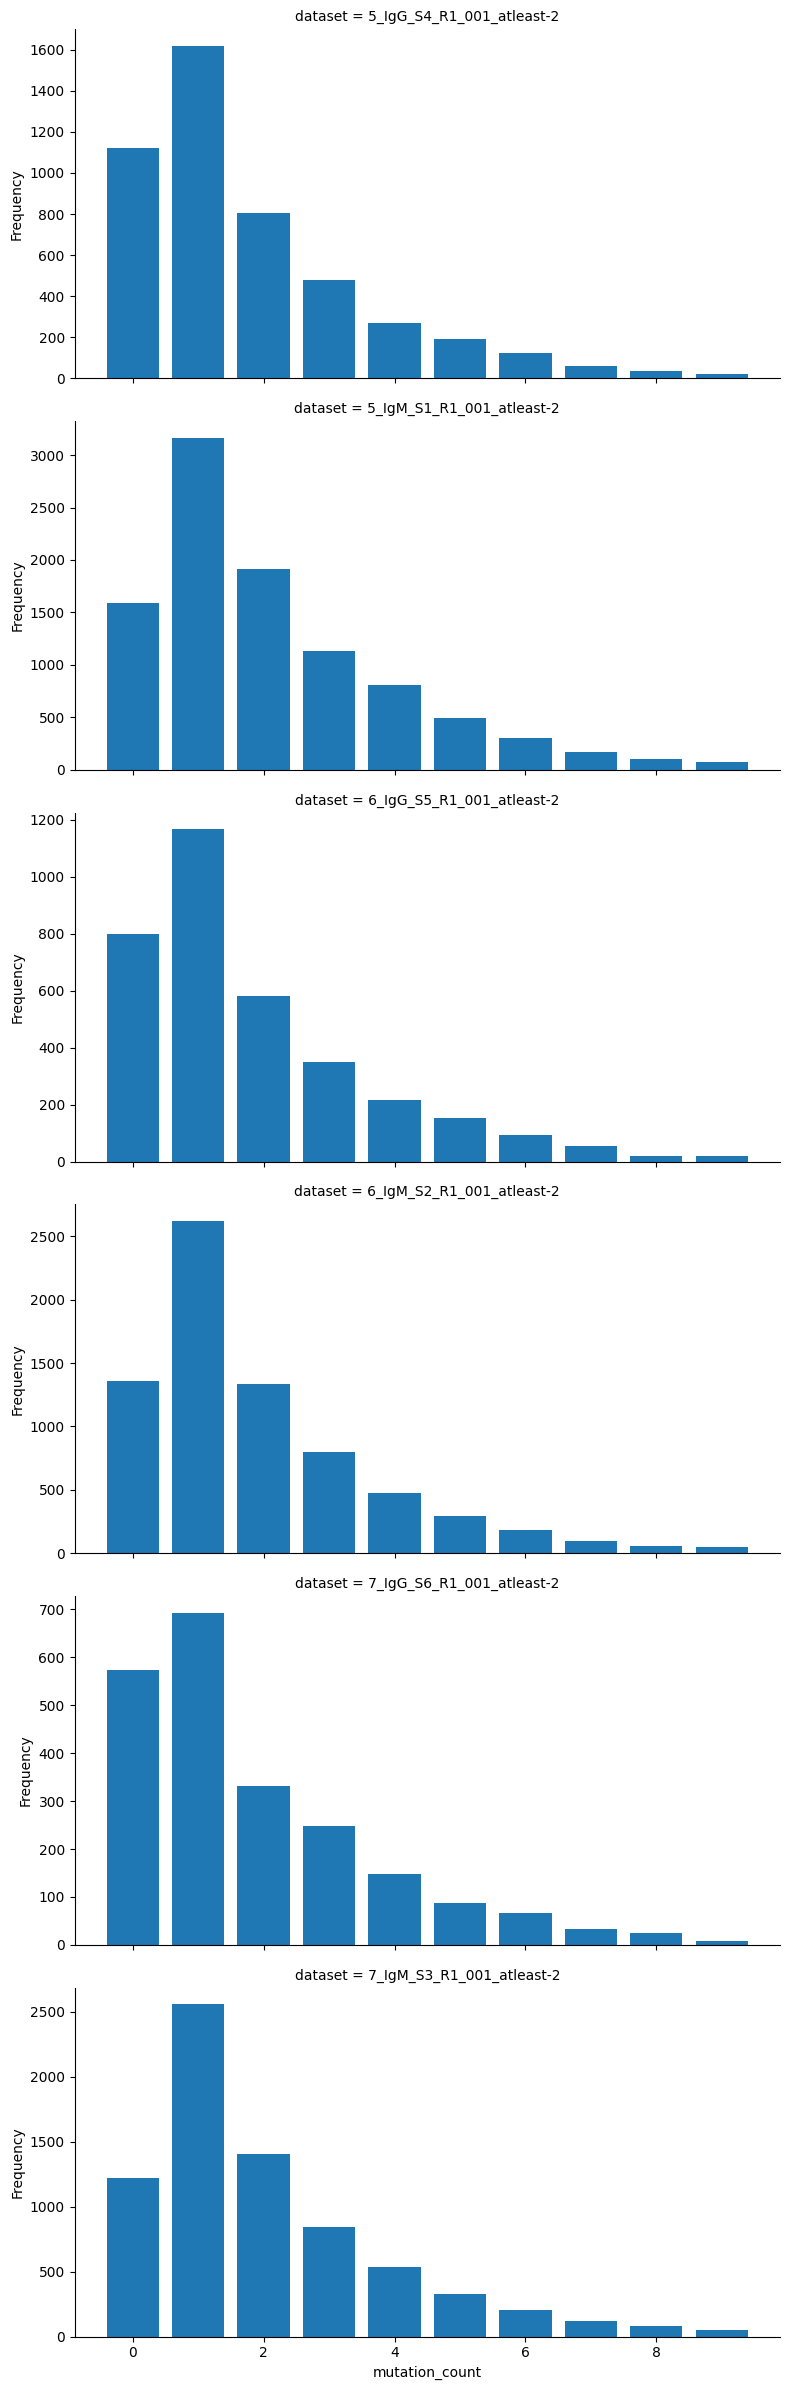

In [16]:
passenger.make_mutation_histogram(chigy_believable)

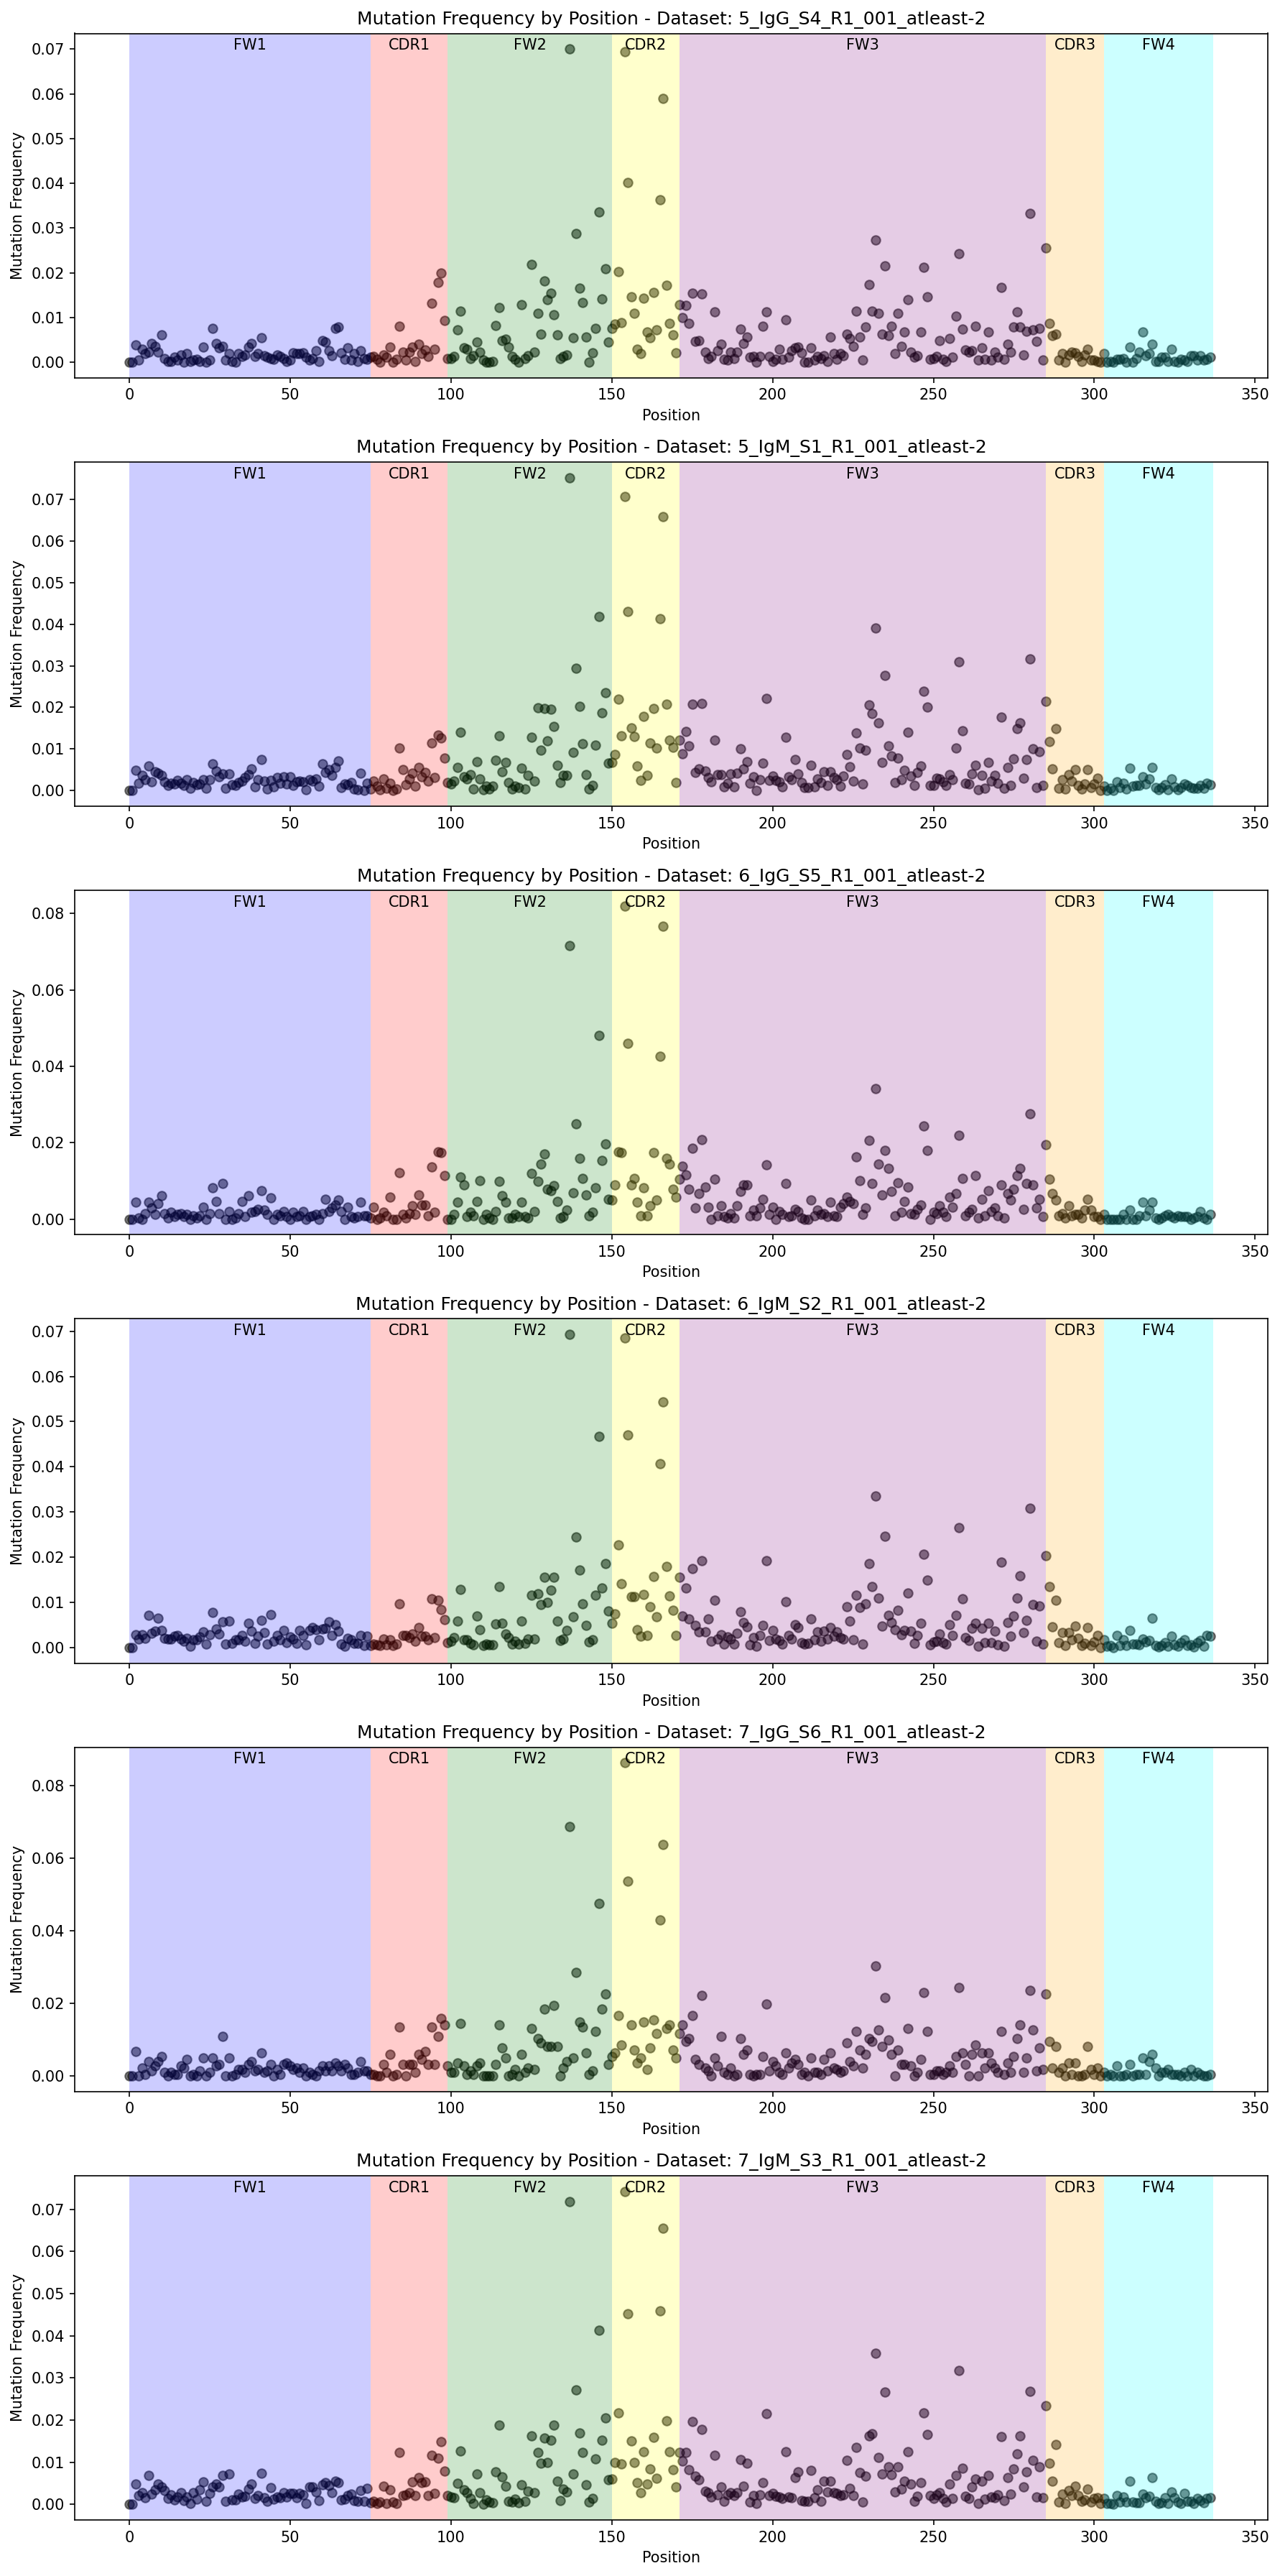

In [17]:
chigy.make_mutation_rate_plot(chigy_believable)


In [18]:
mut_counts_l = []
read_counts_l = []

for name, df in chigy_believable.groupby("dataset"):
    mut_counts = passenger.compute_mutation_counts_by_base(df, chigy.chigy_stop_trimmed)
    nickname = name[:5]
    mut_counts["nickname"] = nickname
    mut_counts_l.append(mut_counts)
    read_counts_l.append({"nickname": nickname, "read_count": len(df)})

read_counts_df = pd.DataFrame(read_counts_l)
read_counts_df.to_csv("output/igh_read_counts.csv", index=False)

mut_counts_df = pd.concat(mut_counts_l)
mut_counts_df.reset_index(names=["position"], inplace=True)
mut_counts_df = mut_counts_df[["nickname", "position", "A", "C", "G", "T"]]
mut_counts_df.to_csv("output/igh_counts_by_base.csv", index=False)
mut_counts_df

,nickname,position,A,C,G,T
0,5_IgG,0,0,0,-1,0
1,5_IgG,1,-1,0,0,0
2,5_IgG,2,12,6,-1,0
3,5_IgG,3,2,0,-1,0
4,5_IgG,4,11,2,1,-1
...,...,...,...,...,...,...
2017,7_IgM,332,0,-1,0,10
2018,7_IgM,333,0,2,5,-1
2019,7_IgM,334,0,-1,2,1
2020,7_IgM,335,-1,0,5,5


In [19]:
mutation_frequency_by_position = passenger.mutation_frequency_by_position_of(chigy_believable)
mut_freq_df = pd.DataFrame({
    "mutation_frequency": mutation_frequency_by_position, 
    "N_frequency": passenger.compute_thing_counts(chigy_believable, "n_positions") / len(chigy_believable)})
mut_freq_df.to_csv("output/igh_n_frequency.csv", columns=["N_frequency"], index=False)
n_rich_df = mut_freq_df.sort_values(by="mutation_frequency", ascending=False).head(20)
n_rich_df

,mutation_frequency,N_frequency
154,0.072894,0.008198
137,0.071772,0.007076
166,0.063372,0.010442
155,0.044933,0.006818
146,0.042632,0.003826
165,0.041682,0.006415
232,0.034577,0.006587
280,0.029716,0.007681
258,0.028018,0.006674
139,0.027299,0.002071


<Axes: xlabel='N_frequency', ylabel='mutation_frequency'>

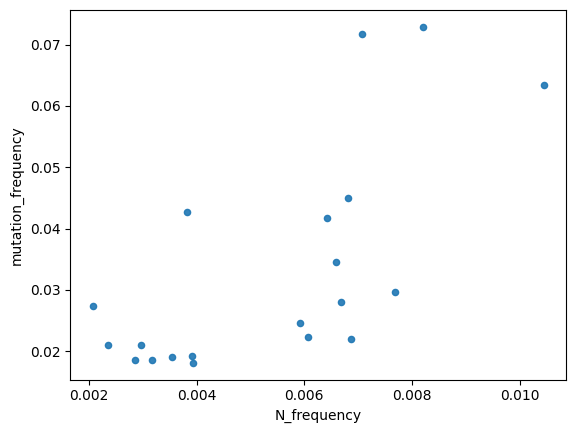

In [20]:
# make a scatter plot of n_rich_df["N_frequency"] versus n_rich_df["mutation_frequency"]
n_rich_df.plot.scatter(x="N_frequency", y="mutation_frequency", alpha=0.9)



#plt.scatter(n_rich_df["N_frequency"], n_rich_df["mutation_frequency"], alpha=0.5)

<Axes: xlabel='N_frequency', ylabel='mutation_frequency'>

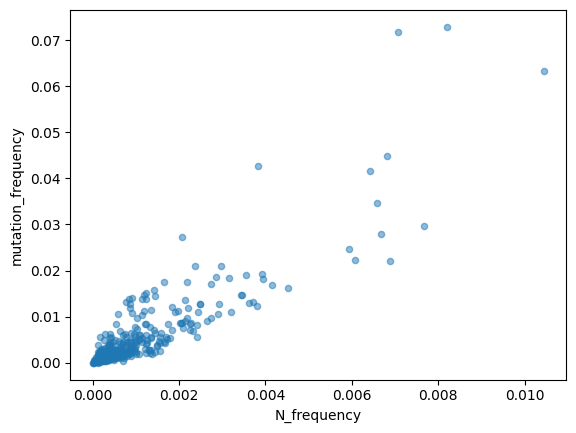

In [21]:
mut_freq_df.plot.scatter(x="N_frequency", y="mutation_frequency", alpha=0.5)